# Sistema Multi-Robôs para Cobertura Eficiente de Ambientes Domésticos

- Bernardo Nogueira Borges
- Daniele Cássia Silva Diniz

Uma aplicação relevante na área de robótica é a dos robôs aspiradores, que têm a
função de percorrer o ambiente doméstico de forma autônoma, recolhendo detritos
ao longo do caminho. Este projeto abordará o problema de cobertura no contexto de
sistemas multi-robôs, com o objetivo de dividir a tarefa entre dois robôs. Um dos
principais desafios nesta área é garantir que os robôs executem seu trajeto de forma
eficiente, evitando a movimentação aleatória pelo espaço, como observado em
robôs aspiradores convencionais, conforme demonstrado no [vídeo](https://www.youtube.com/watch?v=qHEJhJ_CuOQ) da Neato
Robotics

Para superar esses desafios, utilizaremos nosso conhecimento em mapeamento,
controle e algoritmos para desenvolver um sistema de multi-robôs que abordará o
problema de **cobertura** do ambiente de forma eficaz, completa e, adicionalmente,
enfrentaremos o desafio de implementar a colaboração entre os robôs. A
implementação será realizada utilizando a linguagem **Python** e o simulador
**CoppeliaSim**.

Abordar este problema é crucial para aumentar a eficiência energética e reduzir a
pegada de carbono dos robôs aspiradores domésticos. Um planejamento adequado
permite que esses robôs executem suas tarefas de maneira mais rápida e eficiente,
contribuindo significativamente para a sustentabilidade ambiental. As principais
aplicações incluem a limpeza autônoma em residências, escritórios e outros
espaços fechados onde a manutenção regular é necessária.

In [724]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import math

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

## Obtendo o Mapa da Residência

In [725]:
CREATE_PLOTS = True
MAP_NAME = "home"
# MAP_NAME = "diningRoom"

#--------------------------------------------------#

figsize = (8,8)
img = 1 - mpimg.imread(f'./maps/{MAP_NAME}20x20.png')
dims = [10,10] # Dimensoes do mapa (m)
cell_size = 0.5  # Tamanho da celula do grid (m)

In [726]:
# Apenas para garantir que só teremos esses dois valores
threshold = 0.2
img[img > threshold] = 1
img[img<= threshold] = 0

print("Imagem carregada")

Imagem carregada


Grid definida
20
20


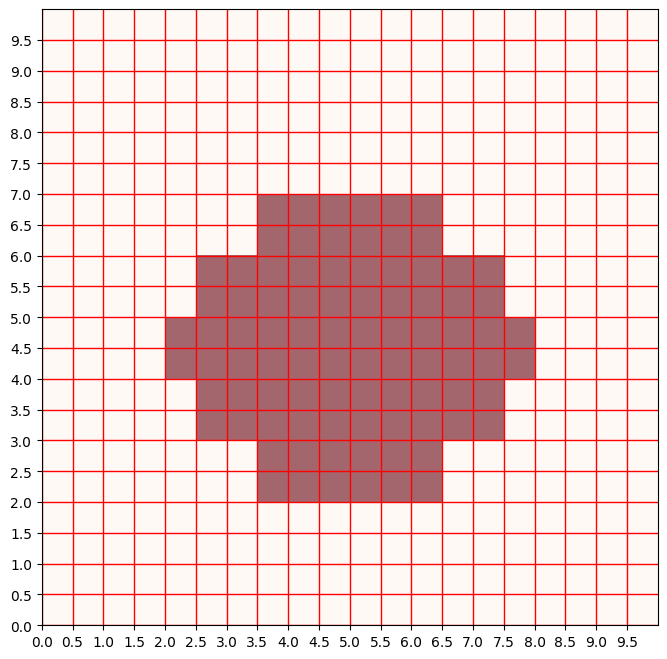

In [727]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array(dims)

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

if CREATE_PLOTS:
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1], cell_size))
    ax.set_yticks(np.arange(0, map_dims[0], cell_size))

print("Grid definida")
print(rows)
print(cols)


## Colored Planner

In [728]:
from enum import Enum

class State(Enum):
    DIRTY = 0
    WALL = 1
    CLEAN = 2

class Color(Enum):
    UNSET = 0
    RED = 1
    BLUE = 2


#          UP     DOWN  RIGHT  LEFT
moves = [(-1, 0),(1, 0),(0,1),(0, -1)]


def isValidCell(i, j, G):
    N = len(G)
    M = len(G[0])
    return 0 <= i < N \
        and 0 <= j < M \
        and G[i][j] == 0

def bfs_multi(blue_src, red_src, G):
    COLOR_GRAPH = np.zeros(G.shape, dtype=[('State', int), ('Color', int)])
    COLOR_GRAPH['State'] = G

    q = [blue_src, red_src]
    while q:
        (i, j, c) = q.pop(0)

        if COLOR_GRAPH[i][j]['Color'] != Color.UNSET.value:
            continue

        COLOR_GRAPH[i][j]['Color'] = c.value

        # Each cell 4-Connect
        for (di, dj) in moves:
            di += i
            dj += j

            # Out of bounds
            if not isValidCell(di, dj, G):
                continue

            # Already visited
            if COLOR_GRAPH[di][dj]['Color'] != Color.UNSET.value:
                continue

            q.append((di, dj, c))

    return COLOR_GRAPH


def colorize(G):
    N = len(G)
    M = len(G[0])
    blue_src = None
    for i in range(N):
        for j in range(M):
            if G[i][j] == 0:
                blue_src = (i, j, Color.BLUE)
                break
        if blue_src != None:
            break

    if blue_src == None:
        print("Could not find a blue_src")
        return

    red_src = None
    for i in reversed(range(N)):
        for j in reversed(range(M)):
            if G[i][j] == 0 and (i, j) != (blue_src[0], blue_src[1]):
                red_src = (i, j, Color.RED)
                break
        if red_src != None:
            break

    if red_src == None:
        print("Could not find a red_src")
        return

    return bfs_multi(blue_src, red_src, G)


def plot_color_graph(CG):
    N = len(CG)
    M = len(CG[0])

    # Extract the 'State' and 'Color' values from CG
    states = np.zeros((N, M), dtype=int)
    colors = np.zeros((N, M), dtype=int)
    for i in range(N):
        for j in range(M):
            states[i, j] = CG[i, j]['State']
            colors[i, j] = CG[i, j]['Color']

    # Create a colormap with specified colors
    cmap = plt.cm.colors.ListedColormap(['gray', 'blue', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create the plot
    plt.figure(figsize=(6 * (M / N), 6))
    plt.imshow(colors, cmap=cmap, norm=norm)

    # Add text annotations for the 'State' values
    for i in range(N):
        for j in range(M):
            plt.text(j, i, str(states[i, j]), ha='center', va='center', color='white', fontsize=12)

    plt.colorbar(ticks=[0, 1, 2])
    plt.show()



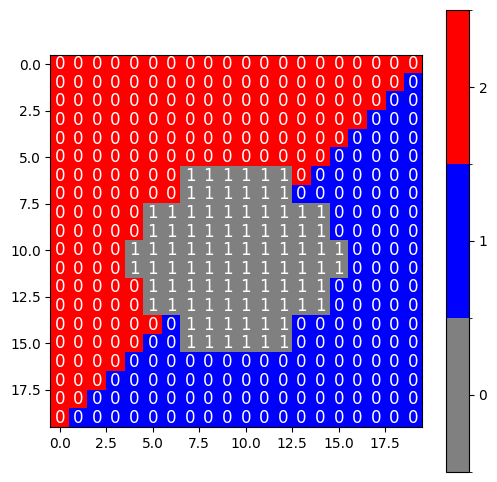

In [729]:
G=grid

CG = colorize(G)
plot_color_graph(CG)

## Localizando com os Mapas

In [730]:
cell_size = 0.5

sceneXrange = (-5,5) # para direita
sceneYrange = (5,-5) # para baixo

gridIrange = (0,20) # para baixo
gridJrange = (0,20) # para direita


def convertLinear(s1, s2):
    (low1, up1) = s1
    (low2, up2) = s2

    def fn(x):
        x -= low1
        if low1 > up1:
            x *= -1
        x /= abs(up1 - low1)
        # Reached 0,1
        x *= abs(up2 - low2)
        if low2 > up2:
            x *= -1
        x += low2
        return x
    return fn


def gridToScene(coords):
    [i, j] = coords
    fx = convertLinear(gridIrange, sceneXrange)
    fy = convertLinear(gridJrange, sceneYrange)
    # TODO add nudge to the middle
    return (fx(j),fy(i))

def sceneToGrid(coords):
    (x, y) = coords
    fj = convertLinear(sceneXrange, gridIrange)
    fi = convertLinear(sceneYrange, gridJrange)
    return [int(fi(y)), int(fj(x))]

In [731]:
def test_conversion(scene,grid):
    print(f"{sceneToGrid(scene)} == {grid}")
    print(f"{gridToScene(grid)} == {scene}")
    return sceneToGrid(scene) == grid and gridToScene(grid) == scene
 
# (-5,-4.5) === [19,0]
print(test_conversion((-5,-4.5),[19,0]))

# (-5,5) === [0,0]
print(test_conversion((-5,5),[0,0]))

# (4.5,5) === [0,19]
print(test_conversion((4.5,5),[0,19]))


[19, 0] == [19, 0]
(-5.0, -4.5) == (-5, -4.5)
True
[0, 0] == [0, 0]
(-5.0, 5.0) == (-5, 5)
True
[0, 19] == [0, 19]
(4.5, 5.0) == (4.5, 5)
True


## Controle

In [732]:
def deLucaOriolo(force, theta):
    kv = 1
    kw = 0.7
    Fx, Fy = force[:2]

    v = kv*(Fx*np.cos(theta) + Fy*np.sin(theta))
    w = kw*(np.arctan2(Fy, Fx) - theta)

    return [v, w]

## Iniciando os Robôs

#### Funções Auxiliares

In [733]:
class Robot():
    def __init__(self, name):
        self.name = name
        self.object = sim.getObject(f"/{name}")
        self.L = 0.230
        self.r = 0.035
        self.left_motor = sim.getObject(f"/{name}/kobuki_leftMotor")
        self.right_motor = sim.getObject(f"/{name}/kobuki_rightMotor")
        self.set_target_velocity(0, 0)

        self.ERROR_MARGIN = 0.2
        self.next_goals = []
        self.current_goal = None

        # DEBUG VISUAL
        self.goal_object = sim.getObject(f"/{name}_Goal")

        # Job Description with designated cells
        self.color = None
        self.dirty_and_designated_cells = 0

    # Control
    def differentialModel(self, v, w):
        wr = ((2.0*v) + (w*self.L))/(2.0*self.r)
        wl = ((2.0*v) - (w*self.L))/(2.0*self.r)
        return [wl, wr]

    def set_target_velocity(self, wl, wr):
        sim.setJointTargetVelocity(self.left_motor, wl)
        sim.setJointTargetVelocity(self.right_motor, wr)

    def get_current_position(self):
        pos = sim.getObjectPosition(self.object)
        ori = sim.getObjectOrientation(self.object)
        q = np.array([pos[0], pos[1], ori[2]])
        return q

    def get_current_location(self):
        (x, y, _) = self.get_current_position()
        return sceneToGrid((x, y))

    # Designated and Dirty Cells Management
    def is_dirty_and_designated_cell(self, i, j):
        if not isValidCell(i, j, G):
            return False

        return CG[i][j]['Color'] == self.color \
            and CG[i][j]['State'] == State.DIRTY.value

    def find_nearest_dirty_and_designated(self):
        """
        Search that travels only on cells with 
        State != WALL
        Color = self.color
        """
        visited = np.zeros(G.shape)
        # print("Initial visited:")
        # print(visited)
        parents = {}

        ri, rj = self.get_current_location()
        visited[ri][rj] = 1
        q = [(ri, rj)]
        target = None

        while q:
            (i, j) = q.pop(0)
            if CG[i][j]['State'] == State.DIRTY.value \
                    and CG[i][j]['Color'] == self.color:
                target = (i, j)
                break

            for (di, dj) in moves:
                ni, nj = i + di, j + dj

                if not isValidCell(ni, nj, G):
                    continue

                if visited[ni][nj]:
                    continue

                visited[ni][nj] = 1
                parents[(ni,nj)] = (i,j)
                q.append((ni,nj))

        if target == None:
            print(f"No target found near {ri,rj}")
            return None

        path = []
        cell = target
        while cell != (ri, rj):
            path.append(cell)
            cell = parents[cell]
        path.reverse()
        return path

    # Goal Management

    def get_current_goal(self):
        if self.current_goal != None:
            return self.current_goal
        if len(self.next_goals) > 0:
            self.current_goal = self.next_goals.pop(0)
            print(f"[{self.name}] new goal is {self.current_goal}")

            # Debug Visual
            q_goal = self.get_goal_position()
            sim.setObjectPosition(self.goal_object, [(q_goal[0]), (q_goal[1]), .2])
            print(f"[{self.name}] set goal at {q_goal[0]} {q_goal[1]}")

            return self.current_goal
        return None

    def get_goal_location(self):
        return self.current_goal

    def get_goal_position(self):
        [gi, gj] = self.current_goal
        (gx, gy) = gridToScene([gi, gj])
        # Goal should be in the middle of cell
        q_goal = np.array([gx+.25, gy-.25, 0])
        return q_goal

    def add_new_goals(self, new_goals):
        self.next_goals.extend(new_goals)

    def has_reached_goal(self):
        if self.current_goal == None:
            return True

        q = self.get_current_position()
        q_goal = self.get_goal_position()
        error = q_goal - q
        print(f"[{self.name}] Error is {error}")
        return np.linalg.norm(error[:2]) < self.ERROR_MARGIN

    def has_goal(self):
        cg = self.get_current_goal()
        return cg != None

    def move_to_goal(self):
        """
        Returns True if no goal left
        """
        self.mark_as_clean()

        if self.get_current_goal() == None:
            print(f"[{self.name}] has no goals.")
            return True

        if self.has_reached_goal():
            print(f"[{self.name}] has reached goal {self.current_goal}")
            # if no new goal,
            if not self.next_goals:
                print(f"[{self.name}] has no new goals.")
                self.current_goal = None
                self.set_target_velocity(0, 0)
                return False

            self.current_goal = None
            self.get_current_goal()

        # TODO: Potential fields to reach current_goal
        q = self.get_current_position()
        q_goal = self.get_goal_position()
        katt = 0.2
        force = katt * (q_goal[:2] - q[:2])
        print(f"[{self.name}] force is {force}")

        theta = sim.getObjectOrientation(self.object)[2]

        # Controle Cinematico
        [v, w] = deLucaOriolo(force, theta)
        # Cinematica inversa
        [wl, wr] = self.differentialModel(v, w)

        self.set_target_velocity(wl, wr)
        return False

    def mark_as_clean(self):
        [ri,rj] = self.get_current_location()

        if CG[ri][rj]['Color'] != self.color:
            return 0

        if CG[ri][rj]['State'] != State.DIRTY.value:
            return 0

        CG[ri][rj]['State'] = State.CLEAN.value
        self.dirty_and_designated_cells -= 1

#### WALL-E

In [734]:
walle = Robot("WALL_E")
print(walle.name, walle.object, walle.left_motor, walle.right_motor)
print(walle.get_current_location())

WALL_E 58 70 75
[14, 16]


#### M-O

In [735]:
mo = Robot("M_O")
print(mo.name, mo.object, mo.left_motor, mo.right_motor)
print(mo.get_current_location())

M_O 88 100 105
[3, 3]


## Controle para andar entre células

In [736]:
def Setup():
    # Identify robot region as RED or BLUE
    [wi,wj] = walle.get_current_location()
    walle_color = CG[wi][wj]['Color']
    [mi,mj] = mo.get_current_location()
    mo_color = CG[mi][mj]['Color']

    # If same region, change walle
    if mo_color == walle_color:
        walle.color = 1 if walle_color == 2 else 2
    else:
        walle.color = walle_color

    mo.color = mo_color

    # TODO:
    # Move robots to designated region
    if walle_color != walle.color:
        print("GOTTA MOVE")
        pass
        
    N = len(CG)
    M = len(CG[0])
    walle.dirty_and_designated_cells = 0
    mo.dirty_and_designated_cells = 0
    # Count dirty cells and dd per robot
    for i in range(N):
        for j in range(M):
            if CG[i][j]['State'] != State.DIRTY.value:
                continue
            if CG[i][j]['Color'] == walle.color:
                walle.dirty_and_designated_cells += 1
            elif CG[i][j]['Color'] == mo.color:
                mo.dirty_and_designated_cells += 1


Setup()

print(f"Dirty cells for WALL_E: {walle.dirty_and_designated_cells}")
print(f"Dirty cells for M_O: {mo.dirty_and_designated_cells}")
print(f"Total dirty cells: {walle.dirty_and_designated_cells+mo.dirty_and_designated_cells}")


Dirty cells for WALL_E: 143
Dirty cells for M_O: 169
Total dirty cells: 312


## Simulação

[WALL_E] Finding goals...
[WALL_E] new goal is [14, 15]
[WALL_E] set goal at 2.75 -2.25
[WALL_E] A close goal [14, 15]
[WALL_E] Error is [-0.65   0.059  0.023]
[WALL_E] force is [-0.13   0.012]
[M_O] Finding goals...
[M_O] new goal is [3, 2]
[M_O] set goal at -3.75 3.25
[M_O] A close goal [3, 2]
[M_O] Error is [-0.669  0.192  0.001]
[M_O] force is [-0.134  0.039]
[WALL_E] Error is [-0.588  0.049  0.045]
[WALL_E] force is [-0.11   0.009]
[M_O] Error is [-0.676  0.242  0.106]
[M_O] force is [-0.135  0.048]
[WALL_E] Error is [-0.351  0.058 -0.159]
[WALL_E] force is [-0.063  0.012]
[M_O] Error is [-0.526  0.306 -0.252]
[M_O] force is [-0.104  0.062]
[WALL_E] Error is [-0.382  0.05   0.064]
[WALL_E] force is [-0.082  0.01 ]
[M_O] Error is [-0.482  0.35  -1.523]
[M_O] force is [-0.096  0.071]
[WALL_E] Error is [-0.495  0.047 -0.065]
[WALL_E] force is [-0.106  0.007]
[M_O] Error is [-0.469  0.325 -2.074]
[M_O] force is [-0.093  0.064]
[WALL_E] Error is [-0.552  0.035 -0.252]
[WALL_E] force is

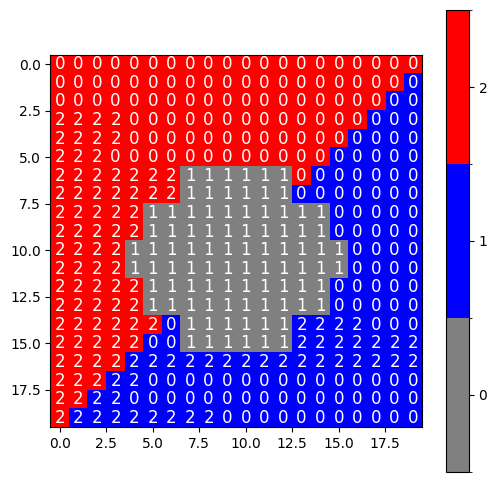

In [737]:
sim.stopSimulation()
sim.startSimulation()

MAX_SIMULATION_TIME = 600

while (t := sim.getSimulationTime()) < MAX_SIMULATION_TIME \
        and (walle.dirty_and_designated_cells + mo.dirty_and_designated_cells) > 0:

    for robot in [walle, mo]:
        # No tasks
        if robot.dirty_and_designated_cells == 0:
            continue

        # Reach goals
        if robot.has_goal():
            robot.move_to_goal()
            continue

        # Find new goals
        print(f"[{robot.name}] Finding goals...")
        [ri, rj] = robot.get_current_location()
        for (dj, di) in moves:
            ni,nj = ri+di,rj+dj
            if robot.is_dirty_and_designated_cell(ni, nj):
                robot.add_new_goals([[ni,nj]])
                break

        # Can go on with goal
        if robot.has_goal():
            print(f"[{robot.name}] A close goal {robot.get_current_goal()}")
            robot.move_to_goal()
            continue

        print(f"[{robot.name}] No close goal at {robot.get_current_location()}")

        # BFS to find nearest cell to clean
        path = robot.find_nearest_dirty_and_designated()
        if path == None:
            print("No path to be found :(")
            continue
        print(f"[{robot.name}] A further goal through {path}")
        robot.add_new_goals(path)
        robot.move_to_goal()

    # All Clean
    sim.step()

sim.stopSimulation()

plot_color_graph(CG)

In [738]:
CG[1][16]['State']

np.int64(0)

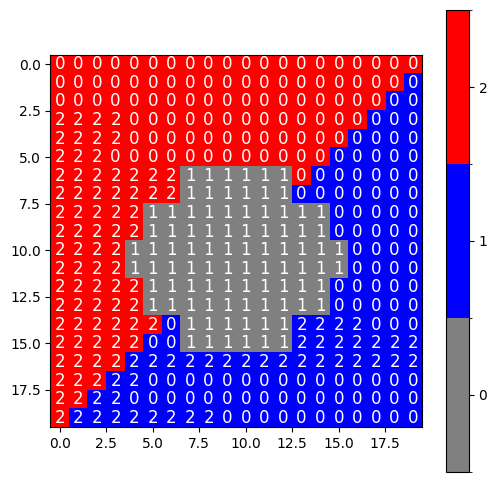

In [739]:
plot_color_graph(CG)